# Emission line analysis

In this tutorial we will analyze the Pa$\beta$ emission line in the $J$ band spectrum of GQ Lup B. This hydrogen emission line is related to the accretion processes in the circumsubstellar disk around this young directly-imaged brown dwarf. The line parameters and uncertainties will be estimated from the continuum-subtracted line profile. For hydrogen lines, the line luminosity will be converted into an accretion luminosity with the coefficients from [Aoyama et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...917L..30A/abstract) and [Marleau & Aoyama (2022)](https://ui.adsabs.harvard.edu/abs/2022RNAAS...6..262M/abstract).

## Getting started

We start by importing the required Python modules.

In [1]:
from species import SpeciesInit
from species.data.database import Database
from species.fit.emission_line import EmissionLine
from species.plot.plot_mcmc import plot_posterior

Next, we initiate the *species* workflow by running the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit) class.

In [2]:
SpeciesInit()

species

Version: 0.9.1.dev64+g1d42feb.d20250418
Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


## Adding data of GQ Lup B to the database

To add data to the HDF5 database, we first create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This object provides read and write access to the HDF5 file.

In [3]:
database = Database()

Next, we will add the available [magnitudes and parallax](https://github.com/tomasstolker/species/blob/master/species/data/companion_data/companion_data.json) and [spectra](https://github.com/tomasstolker/species/blob/master/species/data/companion_data/companion_spectra.json) of GQ Lup B to the database (only the parallax is required later on for calculating the line luminosity) by using the [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This method will add the magnitudes and filter profiles, but it also downloads a flux-calibrated spectrum of Vega and converts the magnitudes into fluxes.

In [4]:
database.add_companion('GQ Lup B')


---------------------
Get companion spectra
---------------------

Getting MUSE spectrum of GQ Lup B... [DONE]
Please cite Stolker et al. 2021, AJ, 162, 286 when making use of this spectrum in a publication
Getting SINFONI_J spectrum of GQ Lup B... [DONE]
Please cite Seifahrt et al. 2007, A&A, 463, 309 when making use of this spectrum in a publication
Getting SINFONI_H spectrum of GQ Lup B... [DONE]
Please cite Seifahrt et al. 2007, A&A, 463, 309 when making use of this spectrum in a publication
Getting SINFONI_K spectrum of GQ Lup B... [DONE]
Please cite Seifahrt et al. 2007, A&A, 463, 309 when making use of this spectrum in a publication

----------
Add object
----------

Object name: GQ Lup B
Units: None
Deredden: None


100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 240MB/s]


Adding spectrum: Vega


Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract
Parallax (mas) = 6.49 +/- 0.03

Magnitudes:
   - HST/WFPC2-PC.F606W:
      - Mean wavelength (um) = 3.7741e+00
      - Apparent magnitude = 19.19 +/- 0.07
      - Flux (W m-2 um-1) = 5.97e-16 +/- 3.85e-17
   - HST/WFPC2-PC.F814W:
      - Mean wavelength (um) = 3.7741e+00
      - Apparent magnitude = 17.67 +/- 0.05
      - Flux (W m-2 um-1) = 1.01e-15 +/- 4.66e-17
   - HST/NICMOS2.F171M:
      - Mean wavelength (um) = 3.7741e+00
      - Apparent magnitude = 13.84 +/- 0.13
      - Flux (W m-2 um-1) = 2.86e-15 +/- 3.43e-16
   - HST/NICMOS2.F190N:
      - Mean wavelength (um) = 3.7741e+00
      - Apparent magnitude = 14.08 +/- 0.20
      - Flux (W m-2 um-1) = 1.63e-15 +/- 3.01e-16
   - HST/NICMOS2.F215N:
      - Mean wavelength (um) = 3.7741e+00
      - Apparent magnitude = 13.40 +/- 0.15
      - Flux (W m-2 um-1) = 1.91e-15 +/- 2.65e-16
   - Magellan/VisAO.ip:
      - Mean wavelen

Not required here, but note that to manually add spectra to the database, it is possible to use the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method. In that case, it is important that the same argument is used for `object_name` as was used as `name` with [add_companion](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_companion) (i.e. *GQ Lup B*).

## Initiating the line analysis

We will now analyze the emission line by first creating an instance of [EmissionLine](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine). The spectrum is read from the database by providing the same object name and spectrum name as were used with [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object). We will select a limited wavelength range around the Pa$\beta$ line by setting the argument of `wavel_range`.

We need to provide either a name for a hydrogen line as argument of ``hydrogen_line`` or the rest wavelength as argument of ``lambda_rest``. If both arguments are set to ``None``, a list names of the available hydrogen lines will be shown and the input can be provided. For the available lines, the rest wavelength (in vacuum) will be automatically calculated and the accretion relation from [Aoyama et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...917L..30A/abstract) will be used to convert the measured line luminosity into an accretion luminosity.

In [5]:
line_analysis = EmissionLine(object_name='GQ Lup B',
                             spec_name='SINFONI_J',
                             hydrogen_line=None,
                             lambda_rest=None,
                             wavel_range=(1.26, 1.32))

100%|█████████████████████████████████████| 2.09k/2.09k [00:00<00:00, 6.66MB/s]

Adding coefficients for accretion relation (2.1 kB)...


/Users/tomasstolker/applications/species/species/fit/emission_line.py:130: UserWarning: Provide an argument for either the 'hydrogen_line' or 'lambda_rest' parameter. Only one of the two arguments should be set to None.
  warnings.warn(


 [DONE]
Please cite Aoyama et al. (2021) and Marleau & Aoyama (2022) when using the accretion relation in a publication
Available hydrogen lines:
['Lya', 'Lyb', 'Lyg', 'Ha', 'Hb', 'Hg', 'Hd', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'Paa', 'Pab', 'Pag', 'Pad', 'Pa8', 'Pa9', 'Pa10', 'Pa11', 'Pa12', 'Pa13', 'Pa14', 'Pa15', 'Pa16', 'Bra', 'Brb', 'Brg', 'Brd', 'Br9', 'Br10', 'Br11', 'Br12', 'Br13', 'Br14', 'Br15', 'Br16']


Please provide the name of the hydrogen line:  Pab


Hydrogen line = Pab
Rest wavelength (um) = 1.2815


Let's have a look at the data of the cropped $J$ spectrum that is extracted.

In [6]:
line_analysis.spectrum

array([[1.26000500e+00, 3.30773946e-15, 1.59113591e-17],
       [1.26014996e+00, 3.32612415e-15, 1.07207200e-17],
       [1.26029503e+00, 3.34623290e-15, 1.09391346e-17],
       ...,
       [1.31959999e+00, 3.39276594e-15, 8.84392665e-18],
       [1.31974494e+00, 3.42414496e-15, 6.28131779e-17],
       [1.31989002e+00, 3.41584644e-15, 3.48663116e-17]], shape=(414, 3))

## Converting line luminosity into accretion luminosity

The [list_hydrogen_lines](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.list_hydrogen_lines) method can be used to list the available names of the hydrogen lines for which the line luminosity can be converted into an accretion luminosity. The conversion is done by using the coefficient for the accretion relation from [Aoyama et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...917L..30A/abstract).

In [7]:
_ = line_analysis.list_hydrogen_lines()

Available hydrogen lines:
['Lya', 'Lyb', 'Lyg', 'Ha', 'Hb', 'Hg', 'Hd', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'Paa', 'Pab', 'Pag', 'Pad', 'Pa8', 'Pa9', 'Pa10', 'Pa11', 'Pa12', 'Pa13', 'Pa14', 'Pa15', 'Pa16', 'Bra', 'Brb', 'Brg', 'Brd', 'Br9', 'Br10', 'Br11', 'Br12', 'Br13', 'Br14', 'Br15', 'Br16']


Since we have set the ``hydrogen_line`` argument of [EmissionLine](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine), we can use the [accretion_luminosity](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.accretion_luminosity) method to manually convert a line luminosity (in $L_\odot$) into an accretion luminosity (in $L_\odot$). Let's give that a try for the Pa$\beta$ line with $L_\mathrm{line} = 10^{-5}$ $L_\odot$.

In [8]:
acc_lum = line_analysis.accretion_luminosity(1e-5)
print(f"Accretion luminosity (Lsun) = {acc_lum:.2e}")

Accretion luminosity (Lsun) = 7.82e-03


## Subtracting the continuum flux

In the $J$ band, we need to subtract the pseudo-continuum of the atmospheric emission. To do so, we make use of the [subtract_continuum](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.subtract_continuum) method of [EmissionLine](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine). The continuum is modeled with a 3rd order polynomial (after smoothing the spectrum) and we use a linear least square fitting algorithm to optimize the parameters. A plot with the best-fit polynomial and the continuum-subtracted spectrum is created, which can be inspected before continuing with the line analysis.

Fitting continuum... [DONE]
Plotting continuum fit... [DONE]


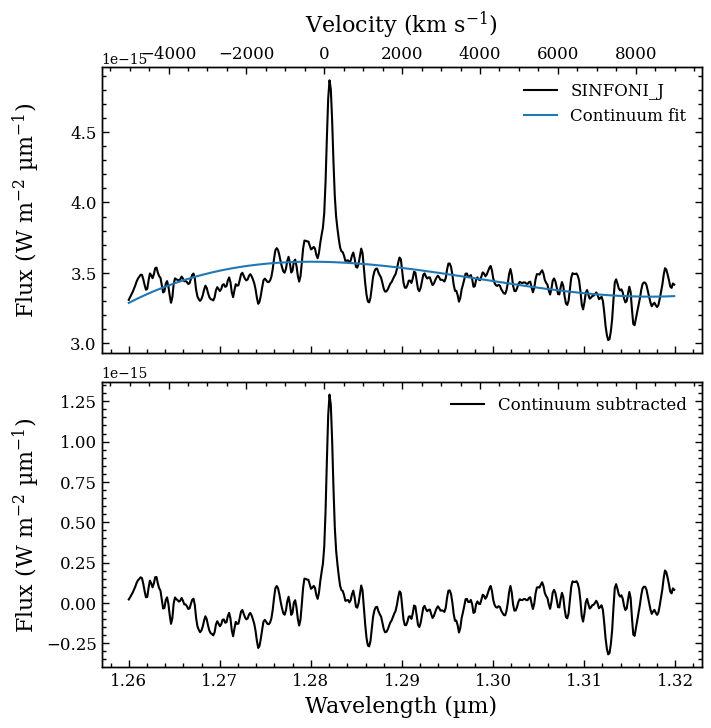

In [9]:
line_analysis.subtract_continuum(poly_degree=3,
                                 plot_filename=None)

## Integrating the line flux

Now that the continuum is subtracted, we can determine the line characteristics in two different ways. Here, we will measure the line properties directly from the spectrum. Later on, we will fit a Gaussian profile and adopt the sampled parameters for inferring the line properties.

We use the [integrate_flux](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.integrate_flux) method to integrate the line flux across the specified wavelength range of ``wavel_int`` after interpolating the spectrum to $R = 100000$. Several other characteristics are also calculated from the spectral line. The uncertainties are estimated by sampling 1000 random spectra from the errors on the fluxes.

Plotting integrated line... [DONE]


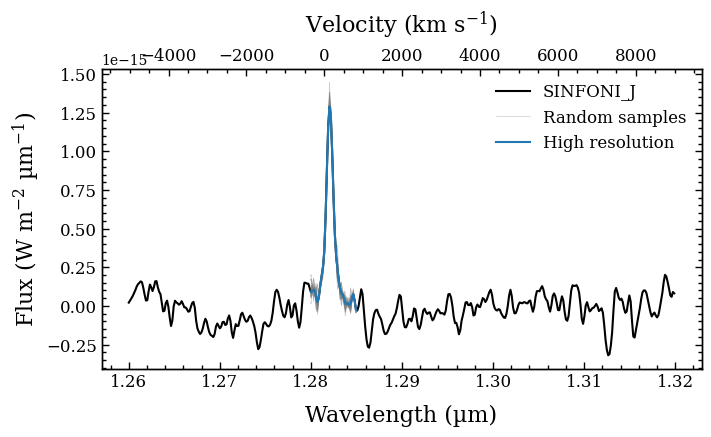

Mean wavelength (nm) = 1282.09 +/- 0.02
FWHM (km s-1) = 202.85 +/- 8.37
Radial velocity (km s-1) = 144.6 +/- 5.6
Line flux (W m-2) = 1.44e-18 +/- 2.78e-20
Line luminosity (Lsun) = 1.07e-06 +/- 2.06e-08
Line luminosity log10(L/Lsun) = -5.97 +/- 0.01
Inflating the uncertainty on the accretion luminosity by 0.3 dex
 to account for the model uncertainty (see Aoyama et al. 2021)...
Accretion luminosity log10(L/Lsun) = -2.94 +/- 0.30


(np.float64(1.4449055877393239e-18), np.float64(2.775041399527963e-20))

In [10]:
line_analysis.integrate_flux(wavel_int=(1.280, 1.285),
                             interp_kind='linear',
                             plot_filename=None)

## Modeling the Pa$\beta$ emission line

We will now use the [fit_gaussian](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.fit_gaussian) method of [EmissionLine](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine) to fit the spectrum with a Gaussian function while mapping the posterior distributions of the 3 free parameters (amplitude, mean, and standard deviation) with the nested sampling algorithm of [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html). 

The argument of `bounds` is a dictionary with the prior boundaries of the three parameters (`gauss_amplitude`, `gauss_mean`, and `gauss_sigma`). If any parameter is missing or `bounds=None` then conservative boundaries will be estimated from the spectrum. The posterior samples will be stored in the database with the `tag` name and a plot is created with a comparison of the data and best-fit model (i.e. the median parameter values).

Creating directory for new run ultranest/run1
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+07  
[ultranest] Likelihood function evaluations: 63970
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -1.325e+07 +- 0.1328
[ultranest] Effective samples strategy satisfied (ESS = 1764.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
Log-evidence = -13250634.33 +/- 0.24
Best-fit parameters (mean +/- std):
   - gauss_amplitude = 1.24e-15 +/- 1.07e-17
   - gauss_mean = 1.28e+00 +/- 5.82e-06
   - gauss_sigma = 4.29e-04 +/- 5.77e-06
Maximum likelihood sample:
   - Log-likelihood = -1.33e+07
   - gauss_amplitude = 1.24e-15
   - ga

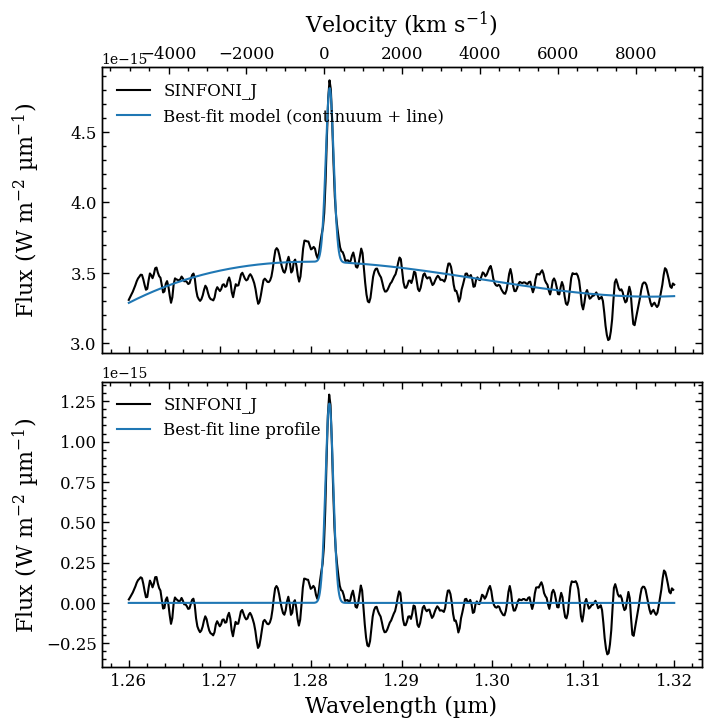

In [11]:
line_analysis.fit_gaussian(tag='pa-beta',
                           min_num_live_points=400,
                           bounds={'gauss_amplitude': (0., 2e-15)},
                           output='ultranest',
                           plot_filename=None,
                           show_status=False)

## Plotting the posterior distributions

Now that the posterior samples are available in the database, we can use the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function for visualizing the 1D and 2D projected distributions with [corner.py](https://corner.readthedocs.io). The argument of `tag` is set to the same database tag that was used with [fit_gaussian](https://species.readthedocs.io/en/latest/species.fit.html#species.fit.emission_line.EmissionLine.fit_gaussian).

Median sample:
   - gauss_amplitude = 1.24e-15
   - gauss_mean = 1.28e+00
   - gauss_sigma = 4.30e-04
   - gauss_fwhm = 2.37e+02
   - line_flux = 1.33e-18
   - log_line_lum = -6.01e+00
   - log_acc_lum = -2.97e+00
   - line_eq_width = -3.72e+00
   - line_vrad = 1.39e+02
   - parallax = 6.49e+00
Maximum posterior sample:
   - gauss_amplitude = 1.25e-15
   - gauss_mean = 1.28e+00
   - gauss_sigma = 4.25e-04
   - gauss_fwhm = 2.34e+02
   - line_flux = 1.33e-18
   - log_line_lum = -6.00e+00
   - log_acc_lum = -2.83e+00
   - line_eq_width = -3.73e+00
   - line_vrad = 1.40e+02
   - parallax = 6.49e+00
Plotting the posterior...

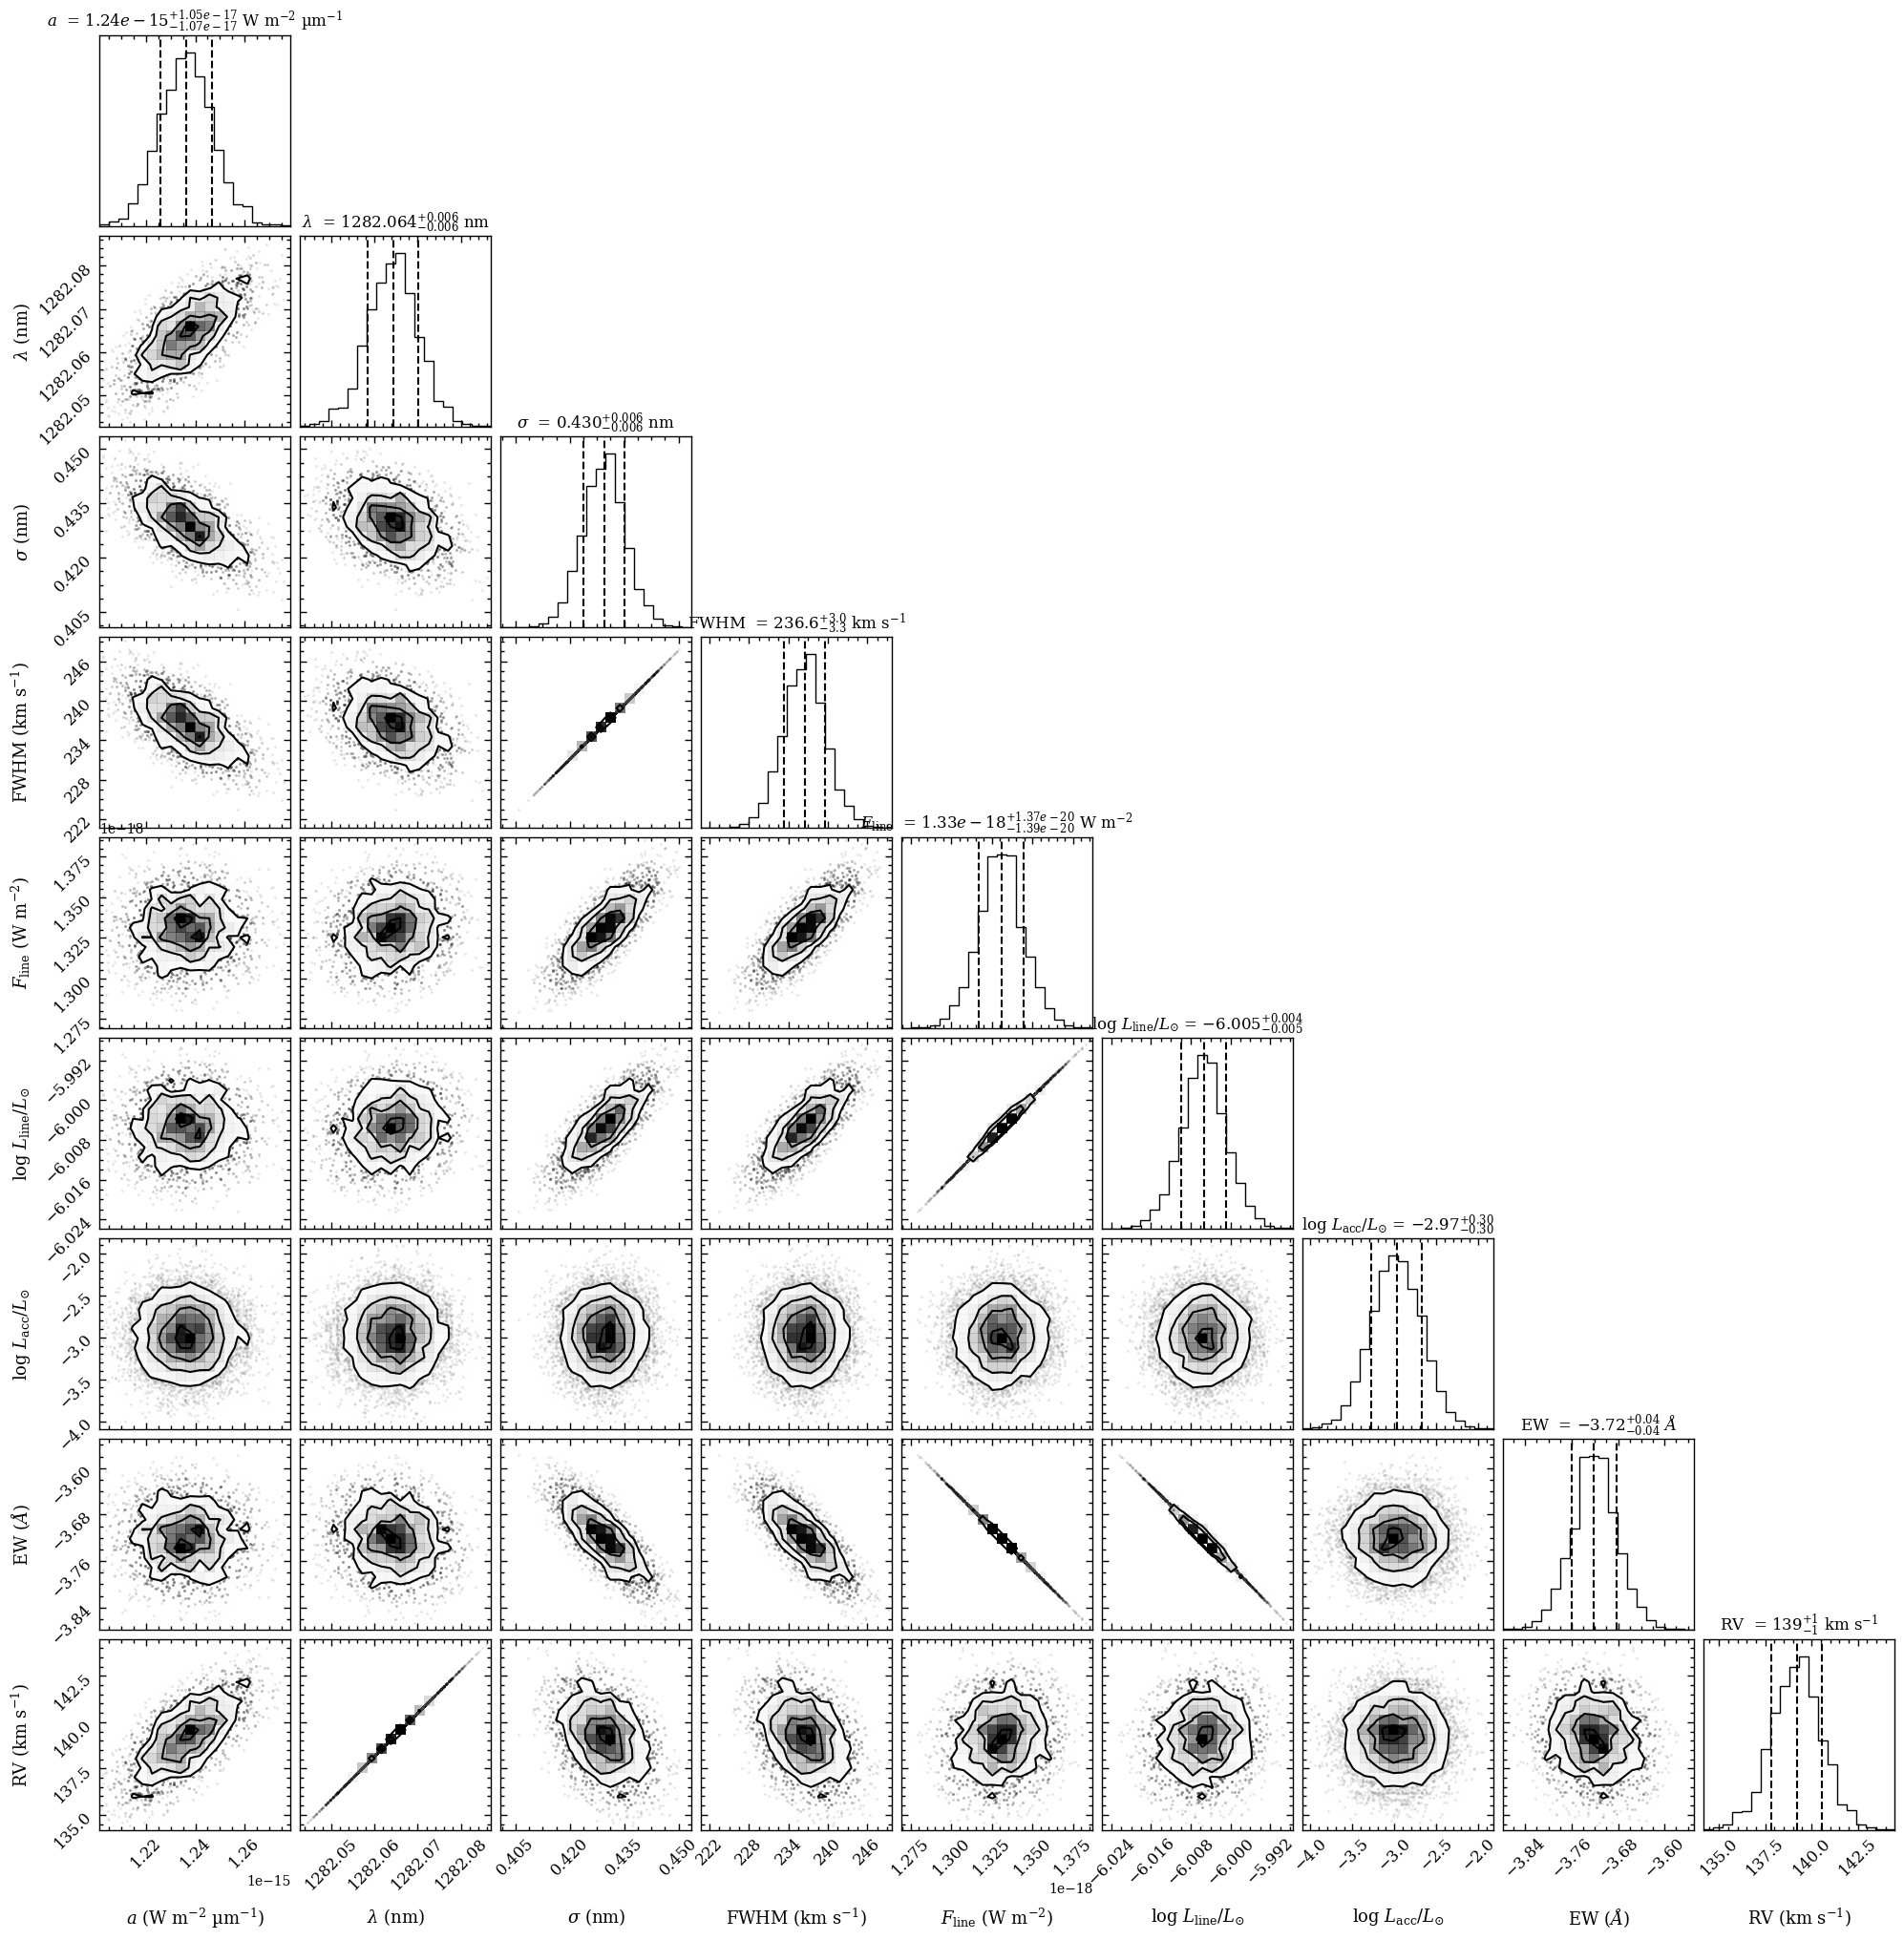

 [DONE]


In [12]:
fig = plot_posterior(tag='pa-beta',
                     title_fmt=['.2e', '.3f', '.3f', '.1f', '.2e', '.3f', '.2f', '.2f', '.0f'],
                     offset=(-0.4, -0.35),
                     output=None)

The first three parameters (from left to right) are the free parameters while the FWHM velocity, line flux, line luminosity, accretion luminosity, equivalent width, and radial velocity have been calculated from the posterior distributions of these three Gaussian model parameters.

The [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.